<a href="https://colab.research.google.com/github/ayushtyagi04/data-analytics-projects/blob/main/P1_Ayush_Tyagi_m_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  --quiet yfinance

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr
import yfinance as yf


import datetime as dt
import time
from scipy import stats

sns.set_style('whitegrid')

%matplotlib inline

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
weights = np.array([0.25, 0.25, 0.25, 0.25])


start = dt.datetime(2020, 6, 23)
end = dt.datetime.today()


prices = pd.DataFrame()

# Fetch data
for ticker in tickers:
    print(f"Fetching {ticker}...", end=" ")
    try:
        df = yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            auto_adjust=True
        )
        series = df['Close']
        print("✓ yfinance", end="")
    except Exception as e:
        print(f"✗ yfinance ({e}); falling back to Stooq...", end="")
        df2 = pdr.DataReader(ticker, 'stooq', start, end)
        df2 = df2.sort_index()
        series = df2['Close']


    prices[ticker] = series
    time.sleep(1)
    print()


prices = prices.dropna(how='all').ffill().bfill()


print(prices.tail())

Fetching AAPL... ✓ yfinance
Fetching MSFT... ✓ yfinance
Fetching GOOGL... ✓ yfinance
Fetching AMZN... ✓ yfinance
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-17 00:00:00-04:00  195.639999  478.040009  175.949997  214.820007
2025-06-18 00:00:00-04:00  196.580002  480.239990  173.320007  212.520004
2025-06-20 00:00:00-04:00  201.000000  477.399994  166.639999  209.690002
2025-06-23 00:00:00-04:00  201.500000  486.000000  165.190002  208.470001
2025-06-24 00:00:00-04:00  200.300003  490.109985  166.770004  212.770004


In [ ]:
logR = np.log(prices / prices.shift(1).dropna())
logR.tail()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2025-06-17 00:00:00-04:00,-0.014110,-0.002298,-0.004650,-0.005941
2025-06-18 00:00:00-04:00,0.004793,0.004592,-0.015060,-0.010764
2025-06-20 00:00:00-04:00,0.022235,-0.005931,-0.039304,-0.013406
2025-06-23 00:00:00-04:00,0.002484,0.017854,-0.008739,-0.005835
2025-06-24 00:00:00-04:00,-0.005973,0.008421,0.009519,0.020417


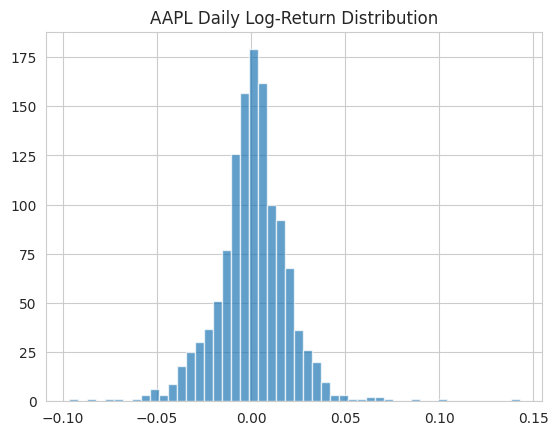

In [ ]:
logR['AAPL'].hist(bins=50 , alpha=0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

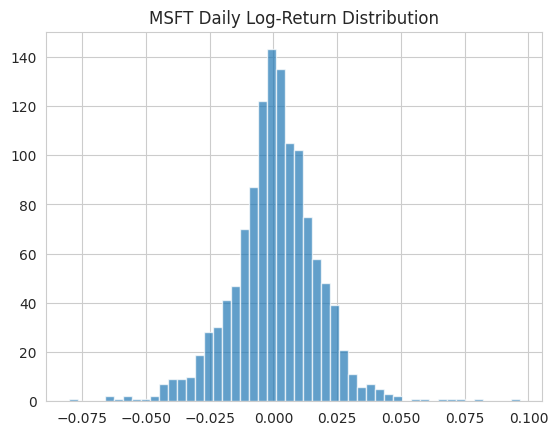

In [ ]:
logR['MSFT'].hist(bins=50 , alpha=0.7)
plt.title('MSFT Daily Log-Return Distribution')
plt.show()

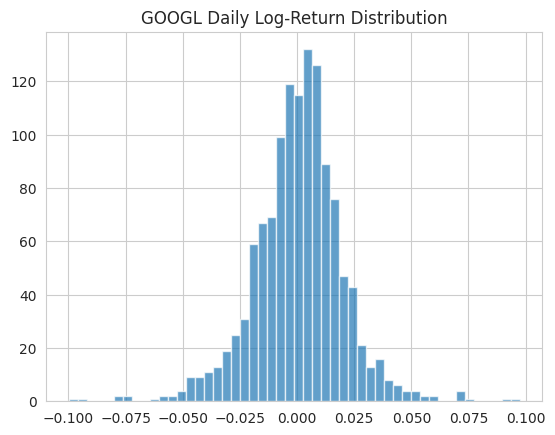

In [ ]:
logR['GOOGL'].hist(bins=50 , alpha=0.7)
plt.title('GOOGL Daily Log-Return Distribution')
plt.show()

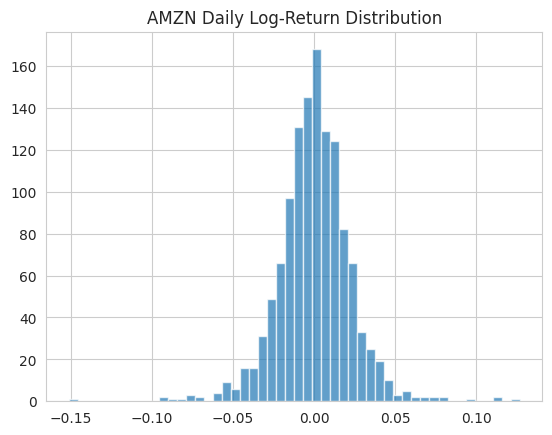

In [ ]:
logR['AMZN'].hist(bins=50 , alpha=0.7)
plt.title('AMZN Daily Log-Return Distribution')
plt.show()

In [ ]:
summary = pd.DataFrame({
    'Mean':logR.mean(),
    'Variance':logR.var(),
    'skewness':logR.skew(),
    'kurtosis':logR.kurtosis()
})


In [ ]:
summary

,Mean,Variance,skewness,kurtosis
AAPL,0.000645,0.000352,0.197199,4.945834
MSFT,0.000740,0.000287,0.006964,2.615564
GOOGL,0.000660,0.000385,-0.154873,2.914097
AMZN,0.000343,0.000505,-0.048585,4.582753


In [ ]:
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof=1)

N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (
    mu_norm - z95 * sigma_norm / np.sqrt(N),
    mu_norm + z95 * sigma_norm / np.sqrt(N)
)


df = N - 1
chi2_low, chi2_high = stats.chi2.ppf([0.025, 0.975], df)
ci_sigma_norm = (
    sigma_norm * np.sqrt(df / chi2_high),
    sigma_norm * np.sqrt(df / chi2_low)
)

print("Normal fit:")
print(f"μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")


Normal fit:
μ = 0.00060, 95% CI (np.float64(5.6819269695300976e-05), np.float64(0.001137750470339744))
σ = 0.01955, 95% CI (np.float64(0.019178373085425127), np.float64(0.019943054370788214))


In [ ]:
returns_flat = logR.stack().values

In [ ]:
df_t,mu_t , sigma_t =stats.t.fit(returns_flat)

Step 1: Bootstrapping Setup


In [ ]:
B=1000

In [ ]:
N =len(returns_flat)

Resample &fit

In [ ]:
estimates=np.array([stats.t.fit(np.random.choice(returns_flat , size=N ,replace =True))
    for _ in range(B)
    ])

In [ ]:
ci_mu_t = np.percentile(estimates[:, 1], [2.5, 97.5])
ci_sigma_t = np.percentile(estimates[:, 2], [2.5, 97.5])

print("\nStundent's t fit:")
print(f" df ={df_t:.1f}, µ={mu_t:.5f}, σ= {sigma_t:.5f}")
print(f" 95% CI for µ (bootstrap):{ci_mu_t}")
print(f" 95% CI for σ (bootstrap):{ci_sigma_t}")


Stundent's t fit:
 df =4.2, µ=0.00088, σ= 0.01436
 95% CI for µ (bootstrap):[0.0004485  0.00135218]
 95% CI for σ (bootstrap):[0.01381828 0.01487063]


In [ ]:
portR = logR.dot(weights)

µ_p =portR.mean()
σ_p =portR.std(ddof=1)

z05 =stats.norm.ppf(0.05)
VaR_norm = - (µ_p + σ_p* z05)
print(VaR_norm)

0.026789059520799238


In [ ]:
t05=stats.t.ppf(0.05, df_t)
VaR_t= - (mu_t + sigma_t * t05) * 1
print(VaR_t)

0.029282717822371723


Historical VaR

In [ ]:
hist_var = -np.percentile(portR, 5)

print("1-Day 95% VaR:")
print(f" Parametric (Normal): {VaR_norm:.5f}")
print(f" Parametric (Student's t): {VaR_t:.5f}")
print(f"Historical (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
 Parametric (Normal): 0.02679
 Parametric (Student's t): 0.02928
Historical (5th percentile): nan


In [ ]:
# One-sample t-test: H0: μ = 0 vs H1: μ ≠ 0
t_stat, p_val = stats.ttest_1samp(portR, 0.0)
print("One-sample t-test on portfolio daily returns:")
print(f"t-statistic = {t_stat:.3f},  p-value = {p_val:.3f}")

if p_val < 0.05:
    print("* Reject H0: mean return is significantly different from zero.")
else:
    print("Fail to reject H0: no evidence mean return ≠ 0.")


One-sample t-test on portfolio daily returns:
t-statistic = nan,  p-value = nan
Fail to reject H0: no evidence mean return ≠ 0.


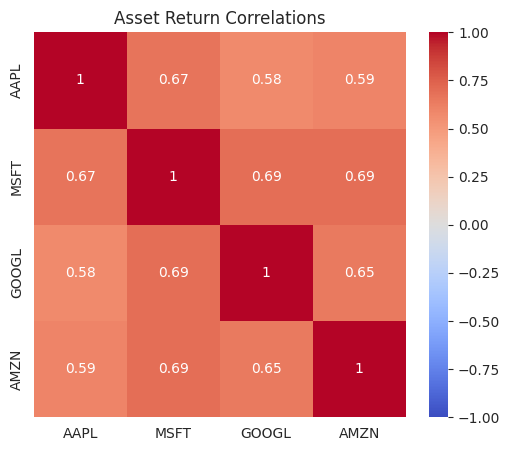

Weighted avg σ:0.0195
Actual portfolio σ:0.0166
Diversification benefit:0.0028


In [ ]:
import seaborn as sns

corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr,annot= True ,cmap='coolwarm',vmin=-1,vmax=1)
plt.title("Asset Return Correlations")
plt.show()

σ_i =logR.std()
σ_weighted = np.dot(weights,σ_i)
σ_portfolio = σ_p
print(f"Weighted avg σ:{σ_weighted:.4f}")
print(f"Actual portfolio σ:{σ_portfolio:.4f}")
print(f"Diversification benefit:{σ_weighted-σ_portfolio:.4f}")

Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


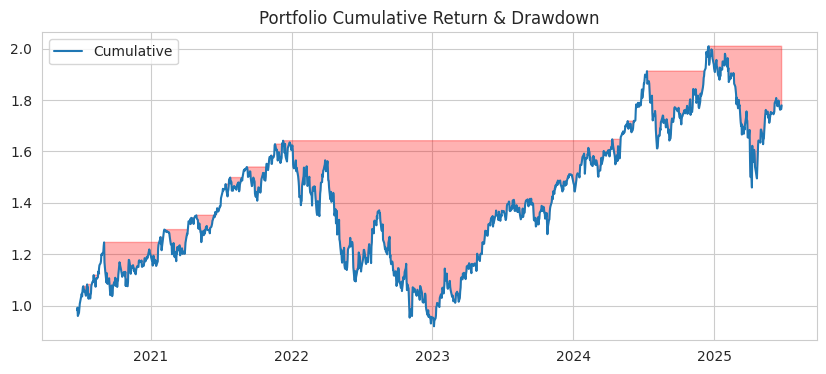

In [ ]:
#8. Max Drawdown

cum_ret = (prices / prices.iloc[0]).prod(axis=1) # cumulative portfolio growth?

#Actually for portfolio: cum_port = (portR + 1).cumprod()

cum_port = (portR + 1).cumprod()

rolling_max = cum_port.cummax()

drawdown = (cum_port - rolling_max) / rolling_max

max_dd = drawdown.min()

end_date = drawdown.idxmin()

start_date = cum_port[:end_date].idxmax()

print(f"Max Drawdown: {max_dd:.2%}")

print(f"From {start_date.date()} to {end_date.date()}")

# Plot

plt.figure(figsize=(10,4))

plt.plot(cum_port, label='Cumulative')

plt.fill_between (drawdown.index, cum_port, rolling_max, where=drawdown < 0, color='red', alpha=0.3)

plt.title('Portfolio Cumulative Return & Drawdown')

plt.legend()

plt.show()

In [ ]:
alpha = 0.05  # for 95% CVaR

# Assume portR is a Series of portfolio returns

# a) Historical Expected Shortfall
es_hist = -portR[portR <= np.percentile(portR, 5)].mean()


# Parametric ES formula: μ - σ·φ(z)/α
es_norm = -(μ_p - σ_p * stats.norm.pdf(z05) / alpha)

# Print results
print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")

Historical ES (95%): nan
Parametric Normal ES (95%): 0.03375


In [ ]:
#10. VaR Backtesting

var_series = -(portR.rolling(1).mean() + portR.rolling(1).std()*z05)

#For simplicity use constant Var_norm

exceptions = portR < -VaR_norm
num_exc =  exceptions.sum()
total = len(portR)
print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 68/1257 days (5.41%, expected ~5%)


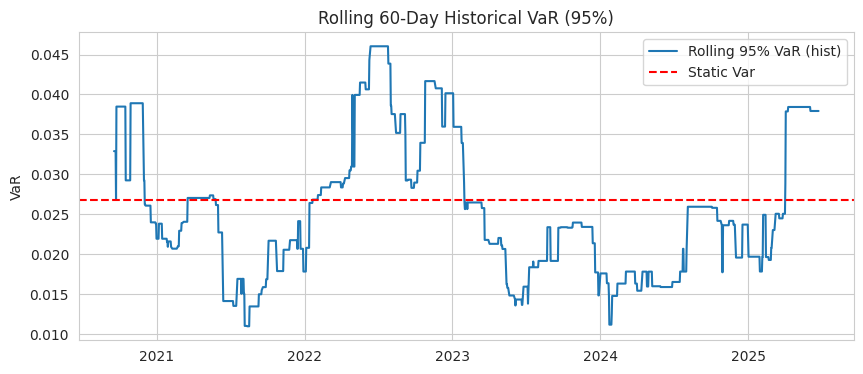

In [ ]:
window = 60
roll_var =  portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VaR_norm, color='red', linestyle = '--', label = 'Static Var')
plt.title('Rolling 60-Day Historical VaR (95%)')

plt.ylabel('VaR')

plt.legend()

plt.show()

In [ ]:
# 12. Jarque-Bera Normality Test
jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")

if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")


JB statistic = nan, p-value = nan
Cannot reject normality.
